<a href="https://colab.research.google.com/github/alracey/level4-project/blob/Higher-dimensions/piecewise_quadratic_2d_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cu126'

This section defines the target function f, the piecewise transform g, and the transformed function h.

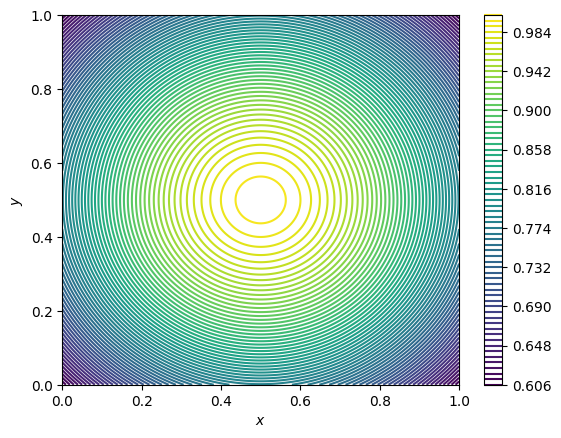

In [5]:
def f(x, y):
  return torch.exp(-((x-0.5)**2 + (y-0.5)**2))

def plot_f(N):
  xs, ys = torch.linspace(0, 1, N), torch.linspace(0, 1, N)
  X, Y = torch.meshgrid(xs, ys, indexing='ij')
  Z = f(X, Y)

  fig = plt.figure()
  plt.contour(X, Y, Z, levels=75, cmap='viridis')
  plt.colorbar()
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()
  return fig

test = plot_f(1000)


In [ ]:
#variance evaluation goes here.  Should be 0.0077

In [ ]:
def g(x, params):   #piecewise quadratic transform with K bins, independent in x, y

  #this version does not yet predict bin widths
  #x.shape = (D, n); params.shape = (D, K-1) where D is dimensions

  #bins
  D, n = x.shape
  K = params.size(1) + 1

  #bin edges (fixed for now)
  bins = torch.stack((torch.linspace(0, 1, K+1), torch.linspace(0, 1, K+1)), dim=0)    #this could be generalised to higher dimensions

  #vertex values
  zeros = torch.zeros((D, 1))
  ones = torch.ones((D, 1))
  v = torch.cat([zeros, params, ones], dim=1)

  #find the correct bin indices i for each x
  i_values = torch.bucketize(x, bins, right=False) - 1

  #create row indices
  row_indices = torch.arange(D).unsqueeze(1)

  #compute the edge positions
  x_left = bins[row_indices, i_values]
  x_right = bins[row_indices, i_values+1]
  w_b = x_right - x_left    #bin width(s)

  v_left = v[row_indices, i_values]
  v_right = v[row_indices, i_values+1]
  w_v = v_right - v_left    #vertex widths

  #transform to local coordinate alpha
  alpha = (x - x_left) / (w_b + 1e-12)    #avoid instability

  #compute cumulative area to the left of arbitrary bin using trapezoid rule as in paper
  area = 0.5 * (v[:, :-1] + v[:, 1:]) * (1.0/K)
  areas = torch.cumsum(area, dim=1)
  c_left = areas[row_indices, (i_values - 1).clamp(min=0)]

  #compute quadratic mappings
  return c_left + ((alpha**2/2) * w_v * w_b) + (alpha * v_left * w_b)


